In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [2]:
train_data = []

print('read train')

for root, subdirs, files in os.walk('data/train'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                train_data.append((label, resampled))
                
print('read test')

test_data = []

for root, subdirs, files in os.walk('data/test'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                test_data.append((label, resampled))

read train


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

read test


  0%|          | 0/160 [00:00<?, ?it/s]

In [3]:
# Prepare the data
labels = [sample[0] for sample in train_data]

print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in train_data]
X = np.array(sequences)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'left_sq_bracket', 'pigtail', 'v', 'caret', 'x', 'delete_mark', 'question_mark', 'triangle', 'left_curly_brace', 'circle', 'star', 'check', 'arrow', 'right_sq_bracket', 'rectangle', 'right_curly_brace'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16
(4096, 50, 2) (1024, 50, 2) (4096, 16) (1024, 16)


# LSTM

In [4]:
def define_model(dimensions, labels):
    # Define the model
    model = Sequential()

    # add LSTM layer
    # input shape is (length of an individual sample, dimensions of the sample)
    # in our case: two dimensions, as we have X and Y coordinates
    model.add(LSTM(dimensions, input_shape=(NUM_POINTS, 2)))

    # add dense layer to do machine learning magic
    model.add(Dense(32, activation='relu'))

    # here, you can add more layers and maybe a dropout for better performance

    # softmax layer for classification
    model.add(Dense(len(set(labels)), activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)
    return model

In [5]:
def train_model(model, X_train, y_train, X_test, y_test, value_of_dimensions):
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)
    # Train the model
    history = model.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[reduce_lr, stop_early]
    )
    model.summary()
    plot_history(history, value_of_dimensions)
    return model

def plot_history(history, value_of_dimensions):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)
    plt.title(f'dimensions: {value_of_dimensions}')

number of dimensions 128:
Epoch 1/30
128/128 [==============================] - 8s 48ms/step - loss: 1.0419 - accuracy: 0.6809 - val_loss: 0.2985 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 2/30
128/128 [==============================] - 5s 43ms/step - loss: 0.2030 - accuracy: 0.9326 - val_loss: 0.1865 - val_accuracy: 0.9502 - lr: 0.0010
Epoch 3/30
128/128 [==============================] - 5s 43ms/step - loss: 0.1217 - accuracy: 0.9670 - val_loss: 0.0833 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 4/30
128/128 [==============================] - 6s 43ms/step - loss: 0.0692 - accuracy: 0.9817 - val_loss: 0.0326 - val_accuracy: 0.9941 - lr: 0.0010
Epoch 5/30
128/128 [==============================] - 6s 45ms/step - loss: 0.0616 - accuracy: 0.9844 - val_loss: 0.0447 - val_accuracy: 0.9873 - lr: 0.0010
Epoch 6/30
128/128 [==============================] - 6s 45ms/step - loss: 0.0513 - accuracy: 0.9871 - val_loss: 0.0463 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 7/30
128/128 [==================

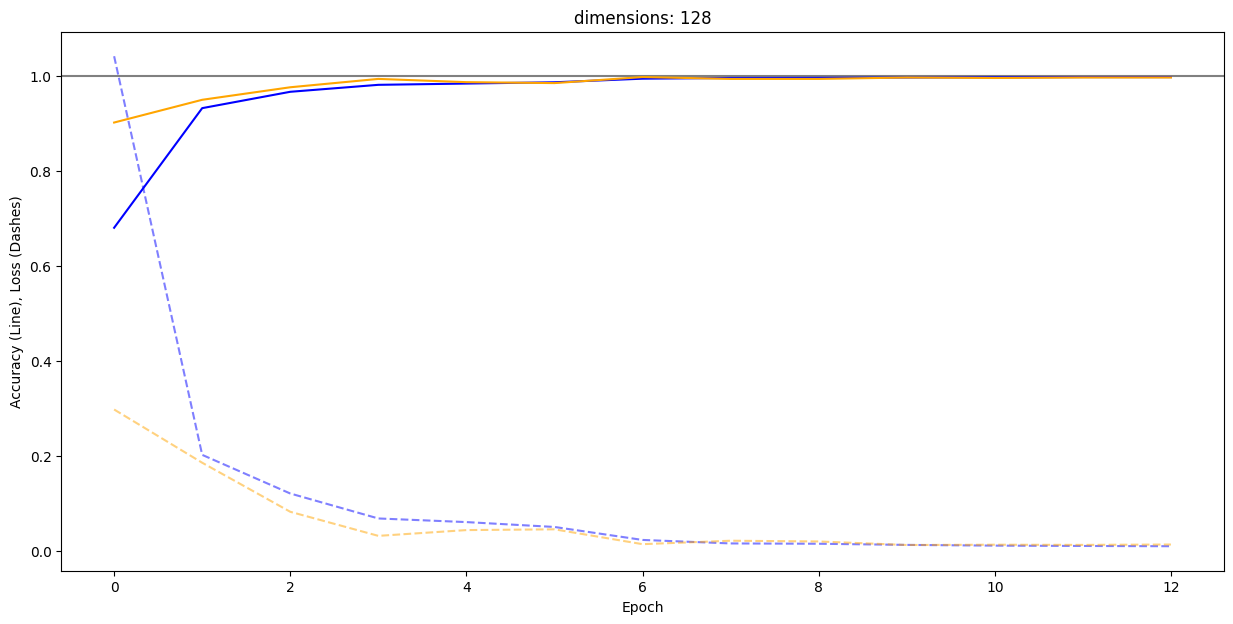

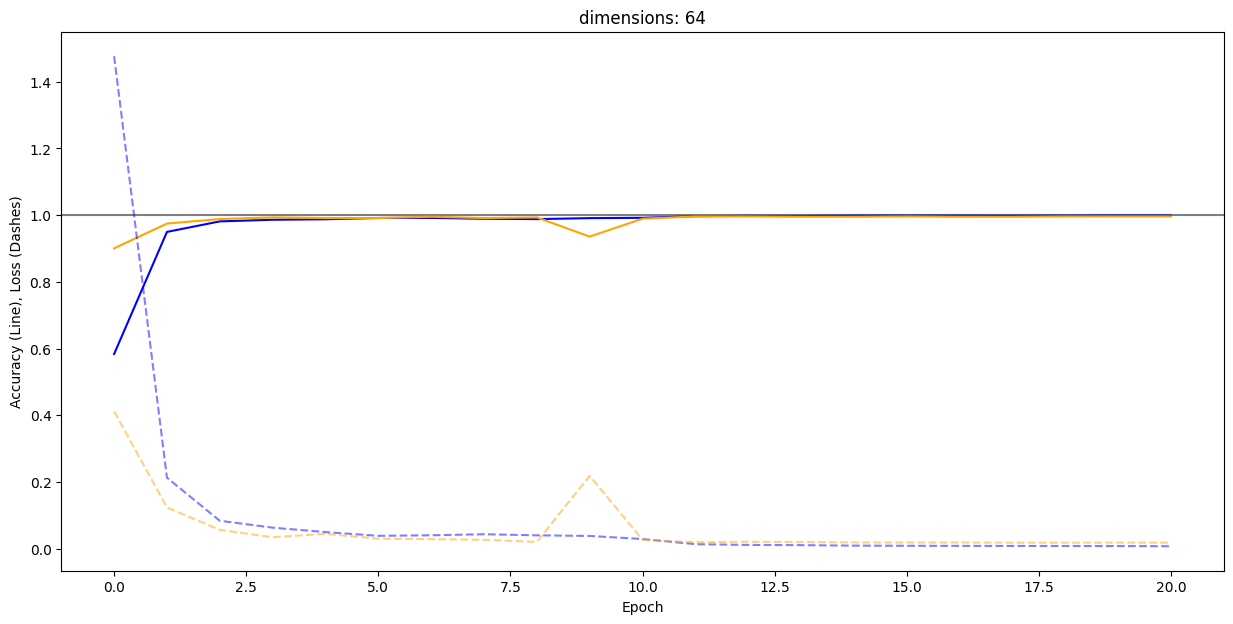

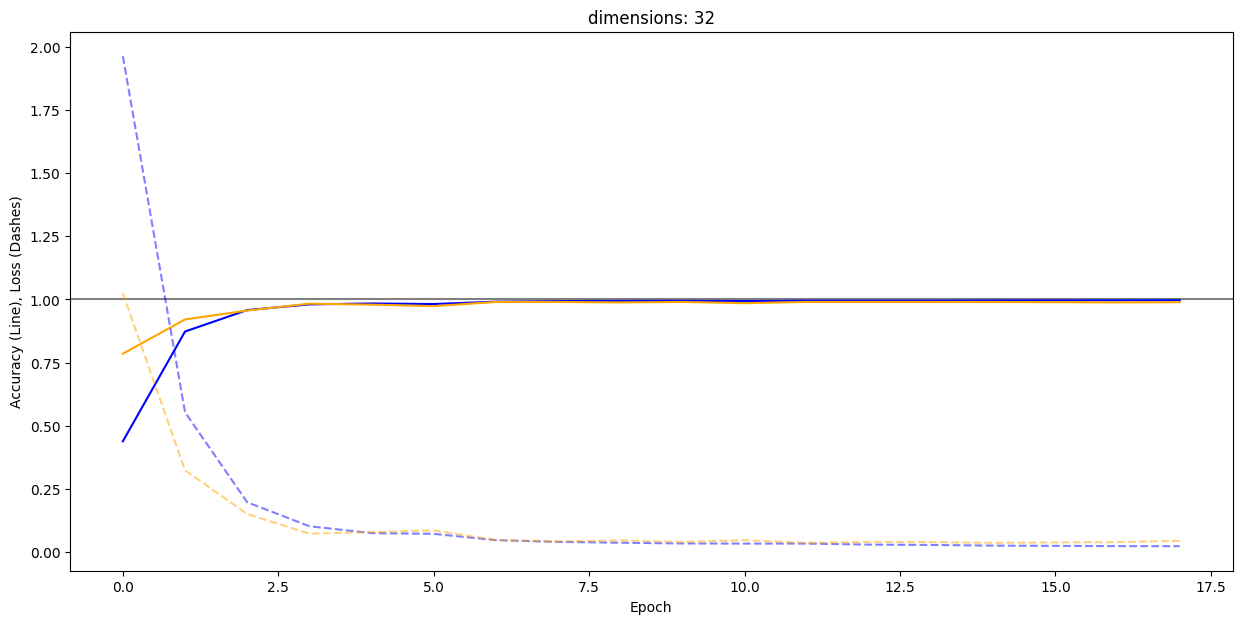

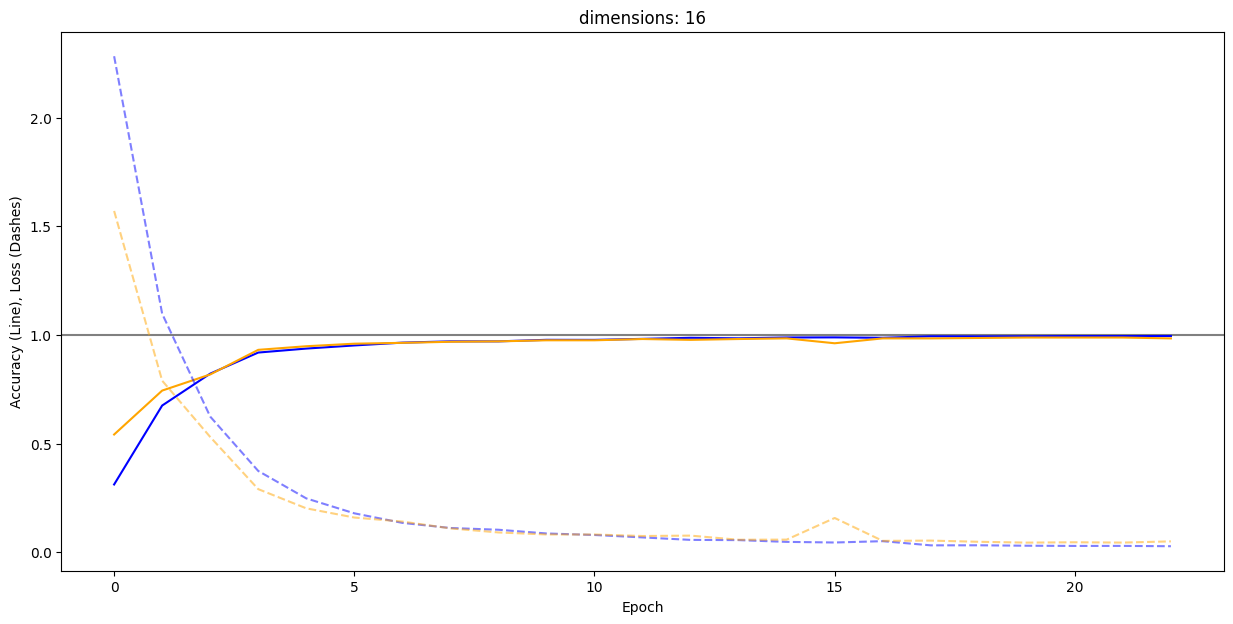

In [8]:
# Here we train the different models
models = []
values_of_dimensions = [128,64,32,16]
for value in values_of_dimensions:
    print(f'number of dimensions {value}:')
    model = define_model(value, labels)
    trained_model = train_model(model, X_train, y_train, X_test, y_test, value)
    models.append(trained_model)

# Test the LSTM's with the prepeared dataset

In [9]:
#prepeare the data
sequences = [sample[1] for sample in test_data]
X = np.array(sequences)

y_labels = [sample[0] for sample in test_data]
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(y_labels)
y_categorical = to_categorical(labels_encoded)


number of dimensions: 128
5/5 [==============================] - 1s 26ms/step
time needed to predict all data points: 0.7757983207702637s
time needed to predict one data point: 0.004848739504814148s
number of dimensions: 64
5/5 [==============================] - 1s 15ms/step
time needed to predict all data points: 0.7137584686279297s
time needed to predict one data point: 0.0044609904289245605s
number of dimensions: 32
5/5 [==============================] - 1s 10ms/step
time needed to predict all data points: 0.5976479053497314s
time needed to predict one data point: 0.0037352994084358217s
number of dimensions: 16
5/5 [==============================] - 0s 8ms/step
time needed to predict all data points: 0.5416688919067383s
time needed to predict one data point: 0.003385430574417114s


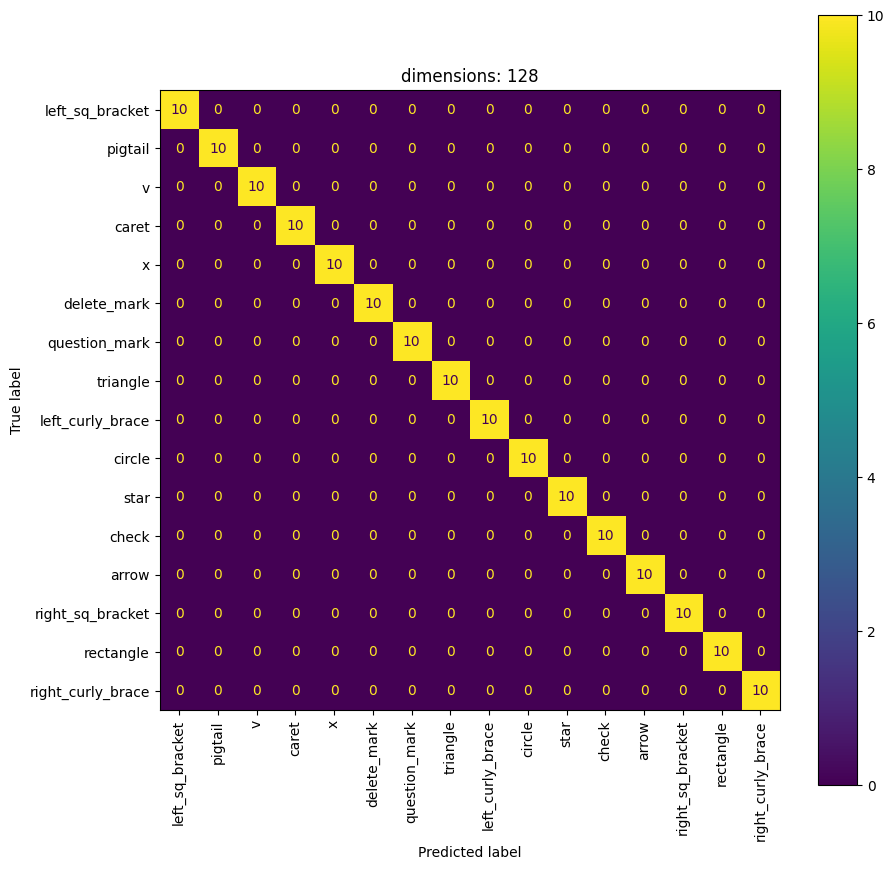

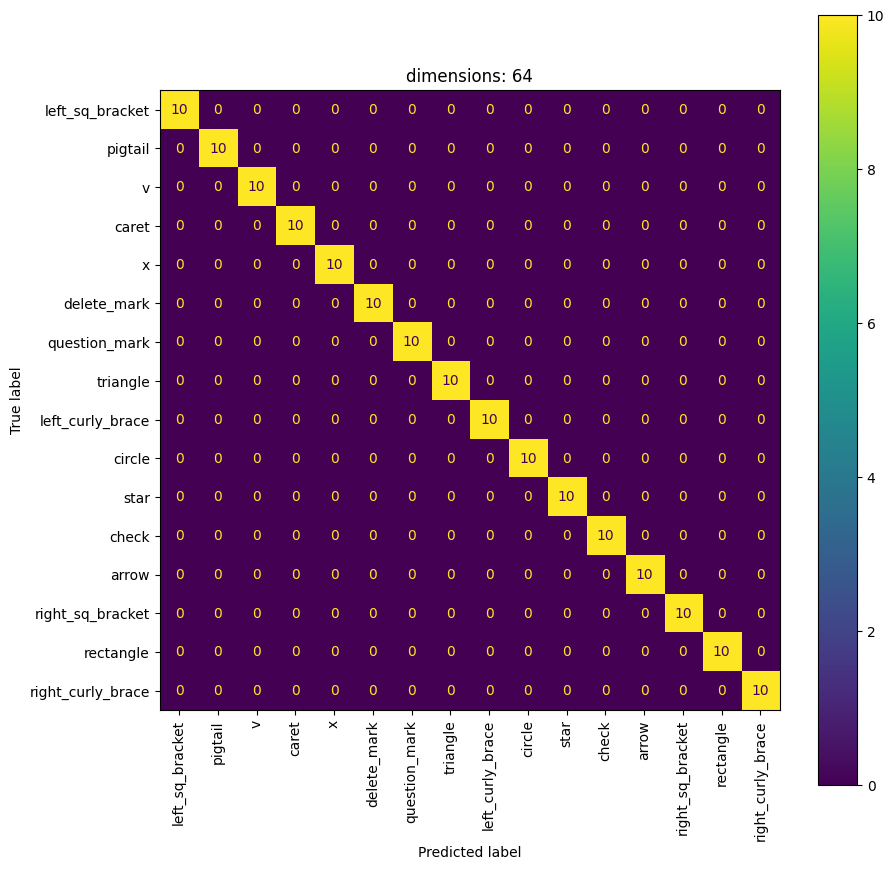

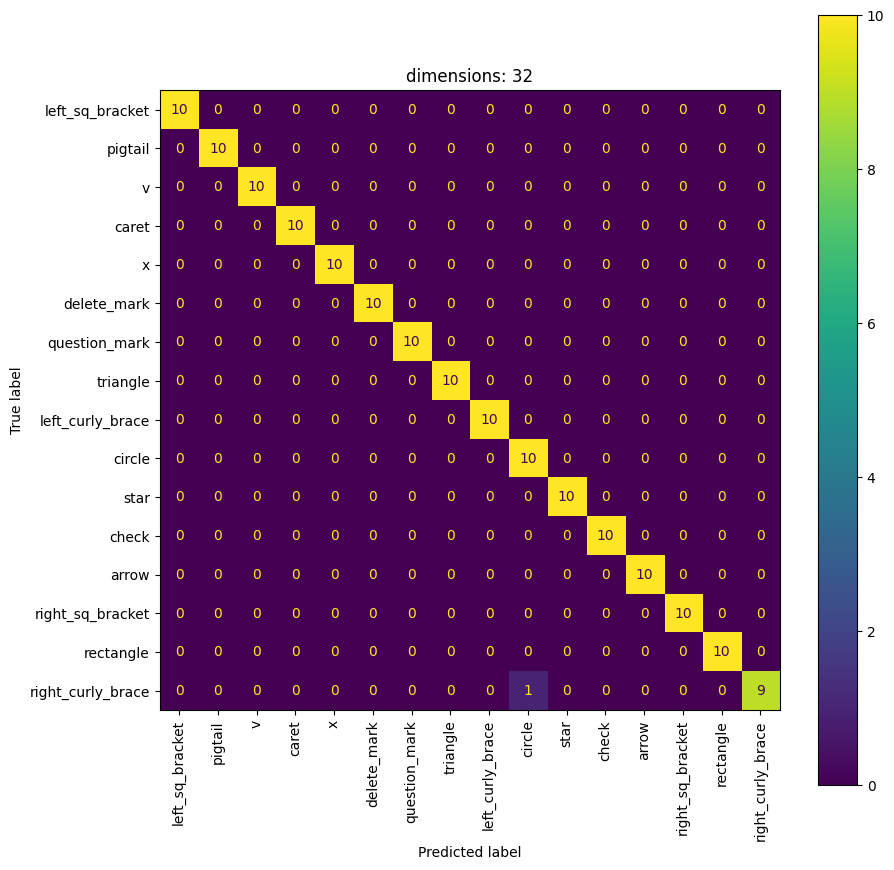

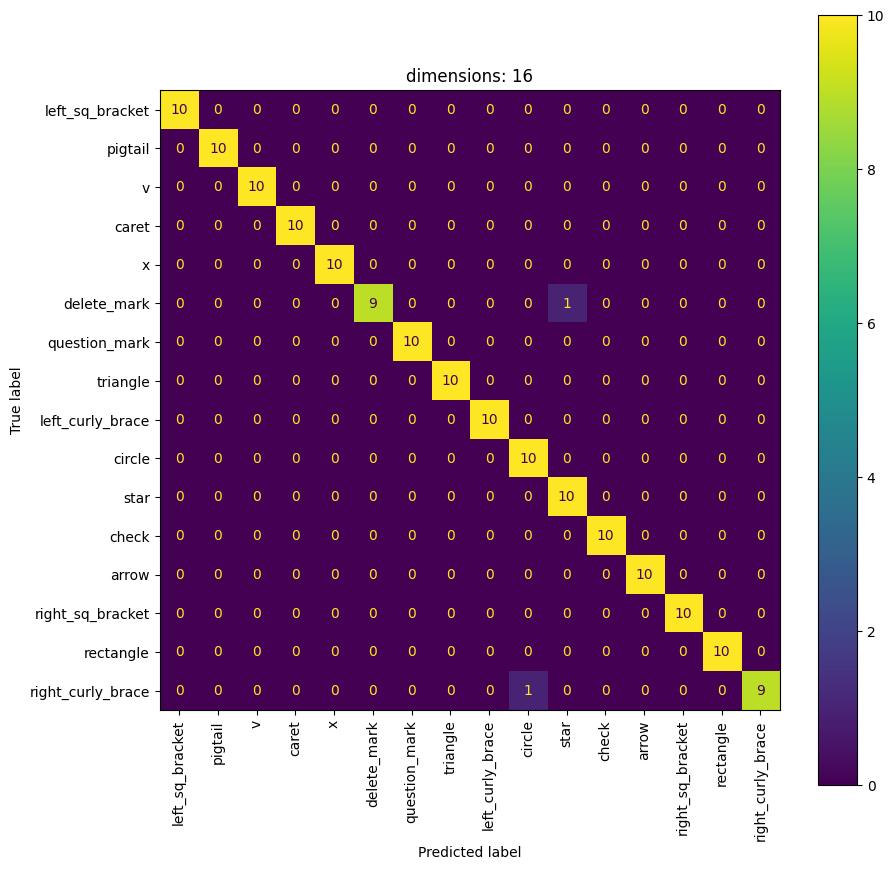

In [12]:
i = 0
for model in models:
    predictions = []
    print(f'number of dimensions: {values_of_dimensions[i]}')
    start_time = time.time()
    y_predictions = model.predict(X)
    end_time = time.time()
    time_needed = end_time - start_time
    print(f'time needed to predict all data points: {time_needed}s')
    print(f'time needed to predict one data point: {time_needed/len(X)}s')
    # to build a confusion matrix, we have to convert it to classifications
    # this can be done by using the argmax() function to set the probability to 1 and the rest to 0
    y_predictions = np.argmax(y_predictions, axis=1)

    y_test_labels = np.argmax(y_categorical, axis=1)

    # create and plot confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_predictions)

    fig = plt.figure(figsize=(10, 10))

    ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

    plt.xticks(rotation=90, ha='center')
    plt.title(f'dimensions: {values_of_dimensions[i]}')
    i += 1

# Prediction with the $1 Recognizer

In [13]:
import dollar_recognicer

recognizer = dollar_recognicer.Dollar_Recognizer(16)

time needed to predict all data points: 4.3527021408081055s
time needed to predict one data point: 0.02720438838005066s


Text(0.5, 1.0, '$1')

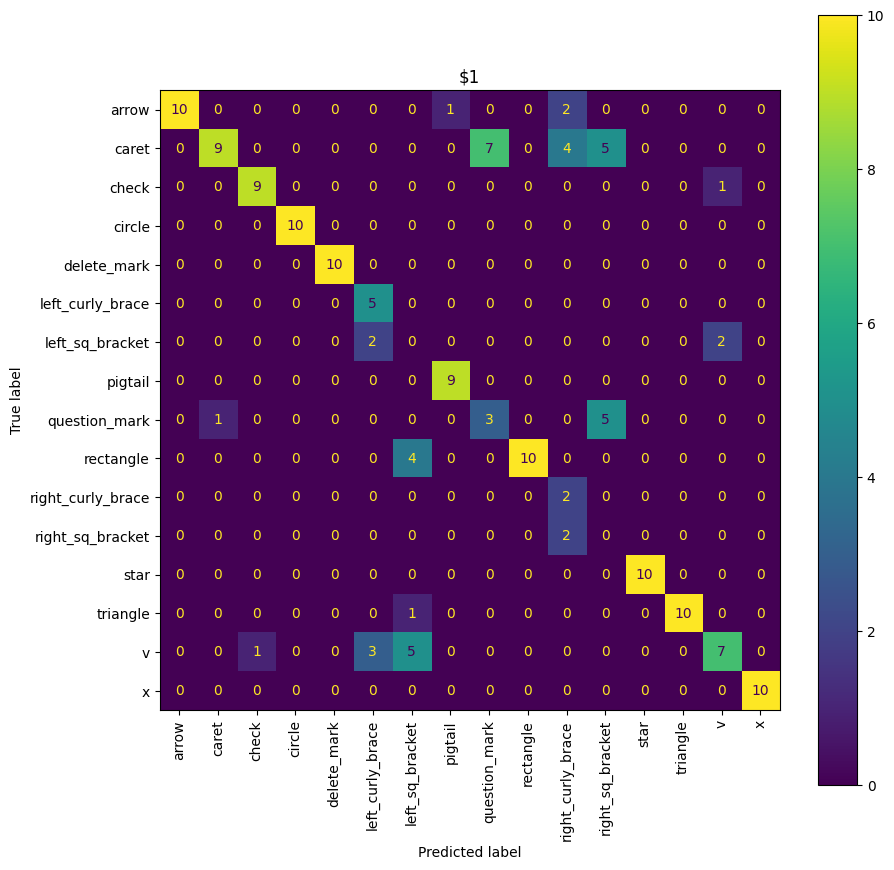

In [17]:
dollar_predictions = []
label_set = ['arrow', 'caret', 'check', 'circle', 'delete_mark', 'left_curly_brace', 'left_sq_bracket', 'pigtail', 'question_mark', 'rectangle', 'right_curly_brace', 'right_sq_bracket', 'star', 'triangle', 'v', 'x']

points_collection = []
for data in X:
    points = []
    for values in data:
        points.append(dollar_recognicer.Point(values[0], values[1]))
    points_collection.append(points)
time = 0
for points in points_collection:
    prediction = recognizer.recognize(points)
    time += prediction.s
    dollar_predictions.append(prediction.name)
print(f'time needed to predict all data points: {time}s')
step_time = time / len(X)
print(f'time needed to predict one data point: {step_time}s')
conf_matrix = confusion_matrix(dollar_predictions, y_labels)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_set).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
plt.title('$1')

# Summary

## Training:

| Model     | acc  | loss  | val_acc  | val_loss  |
|-----------|---|---|---|---|
| LSTM(128) | 0.998  | 0.011  | 0.997  | 0.014  |
| LSTM(64)  | 0.998  | 0.008  | 0.996  | 0.018  |
| LSTM(32)  | 0.997  | 0.023  | 0.989  | 0.039  |
| LSTM(16)  | 0.996  | 0.028  | 0.984  | 0.05  |

For the training all LSTM archive very good results (accuracy for the training data is above 0.99 and for the validation data above 0.98 for all models). The val_acc increases with the number of parameters. The lowest value is produced by the LSTM(16) (0.984) and the highest for the LSTM(128) (0.997). For the difference of 128 and 64 there is only a slightly increase of 0.001. For the accuracy of the training data the models with less parameters have a bigger difference to the val_acc, which indicates more overfitting for those models. 

## Evaluation with the new dataset

| Model     | acc  | prediction time complete data in ms  | prediction time one data point in ms  |
|-----------|---|---|---|
| LSTM(128) | 1      | 775   | 4.85  |
| LSTM(64)  | 1      | 713   | 4.46  |
| LSTM(32)  | 0.994  | 597   | 3.74  |
| LSTM(16)  | 0.988  | 541   | 3.39  |
| $1        | 0.713  | 4000  | 27.20  |

The accuracy is calculated by dividing the number of correct predictions by the number of all predictions.

There is a big difference between the 1 dollar recognizer and the LSTM’s in terms of accuracy and time. In terms of accuracy the $1 recognizer has an accuracy of 0.713 and the LSTM’s archive values over 0.98. The confusion matrix of the 1 dollar recognizer shows that this low accuracy is due to a certain set of gestures (for example curly braces and square braces), but it has a good prediction rate for other gestures like the arrow or the circle.

For the LSTM’s there is a similar trend as in the training. The accuracy gets higher with a higher number of parameters. With the number of parameters, the prediction time also increases. The LSTM(128) and LSTM(68) have the same accuracy but the LSTM with a higher parameter count has a slightly higher prediction time, indicating indicating  that 64 would be enough in this case.

For the question which model should be used when building a real live application, the answer depends on the application. Due to the much better results of the LSTM this model should be preferred. For the number of parameters, it depends if a low prediction time or a higher accuracy is more important for the application. If the the 1 dollar recognizer is used (for example if there is no annotated data for new gestures) the gestures used, should be selected to differ a lot from each other and should be easy recognizable by the 1 dollar recognizer like the arrow.